### Import library

In [256]:
# handle data
import pyspark.sql as ps
from pyspark.sql.functions import from_unixtime,date_format,from_utc_timestamp,col
from pyspark.sql.types import DateType,FloatType,IntegerType
from pyspark.ml.feature import VectorAssembler,MinMaxScaler
from pyspark.ml.functions import vector_to_array
from keras.models import Sequential
from keras.layers import LSTM, Dense 

# train data|
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta

In [338]:
spark = ps.SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "4096m").\
        getOrCreate()
spark.sparkContext.setLogLevel("WARN")

### Read data from hdfs

**Declare period, symbol**

In [258]:
symbol = "BTCUSDT"
PERIOD = "1d"

In [259]:
df = spark.read.parquet(f"hdfs://hadoop-namenode:9000/crypto/{symbol}/{PERIOD}.parquet")

### Processing

In [260]:
# sort df by time
df = df.sort(df["open_time"].asc())

In [261]:
# format open price to float type
df = df.select(["date","open"]).withColumn("open", df["open"].cast(IntegerType()))

In [262]:
# bring "open" column to vector assembler
assember = VectorAssembler(inputCols=["open"],outputCol="feature_vector")
df_transformed = assember.transform(df)

In [263]:
# scale feature vector
scaler = MinMaxScaler(min=0,max=1,inputCol="feature_vector",outputCol="scaled_feature")
scaler = scaler.fit(df_transformed)
df_transformed = scaler.transform(df_transformed)


In [264]:
TRAIN_DATA_LENGTH = int(df_transformed.count() * 0.8)

In [265]:
df = df_transformed.select(["date","scaled_feature"]).withColumn("scaled_feature", vector_to_array("scaled_feature")).select(["date"] + [col("scaled_feature")[i] for i in range(1)])

In [266]:
data = np.array(df.collect())

In [267]:
data

array([[datetime.date(2017, 12, 14), 0.19931896632148524],
       [datetime.date(2017, 12, 15), 0.20404577541437324],
       [datetime.date(2017, 12, 16), 0.2224243555057997],
       ...,
       [datetime.date(2022, 11, 15), 0.20844606151071307],
       [datetime.date(2022, 11, 16), 0.21284634760705293],
       [datetime.date(2022, 11, 17), 0.20913020493205214]], dtype=object)

In [274]:
train_data = data[:TRAIN_DATA_LENGTH]
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 1])
    y_train.append(train_data[i, 1])
    
x_train = np.array(x_train)  
x_train = np.asarray(x_train).astype('float32')
y_train = np.array(y_train)    
y_train = np.asarray(y_train).astype('float32')

x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))

In [275]:
y_train

array([0.07544236, 0.08850328, 0.08278135, ..., 0.24798644, 0.24111392,
       0.21671797], dtype=float32)

### Build model

In [276]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

### Train model

In [277]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1020/1020 [==============================] - 16s 13ms/step - loss: 1.9602e-04


### Test model

In [305]:
test_data = data[TRAIN_DATA_LENGTH:]
x_test = []
y_test = []

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i, 1])
    y_test.append(test_data[i, 1])
    
x_test = np.array(x_test)    
y_test = np.array(y_test)    

x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [327]:
x_test = np.asarray(x_test).astype('float32')
predictions = model.predict(x_test)

21/21 [==============================] - 0s 11ms/step


In [328]:
y_test = []
for i in range(60,len(test_data)):
    y_test.append(test_data[i, 0])
y_test = np.array(y_test)

In [329]:
train = pd.DataFrame(data[:TRAIN_DATA_LENGTH], columns=["date","price"])
train = train.set_index("date")
valid = pd.DataFrame(data[TRAIN_DATA_LENGTH:], columns=["date","price"])
valid = valid.set_index("date")

In [330]:
predictions = np.concatenate((y_test.reshape((-1,1)),predictions.reshape((-1,1))), axis=1)
predictions = pd.DataFrame(predictions, columns=["date","price"])
predictions = predictions.set_index("date")

In [331]:
predictions

,price
date,
2021-01-27,0.460814
2021-01-28,0.459286
2021-01-29,0.453459
2021-01-30,0.456248
2021-01-31,0.46543
...,...
2022-11-13,0.226238
2022-11-14,0.217931
2022-11-15,0.210977


### Plot the data

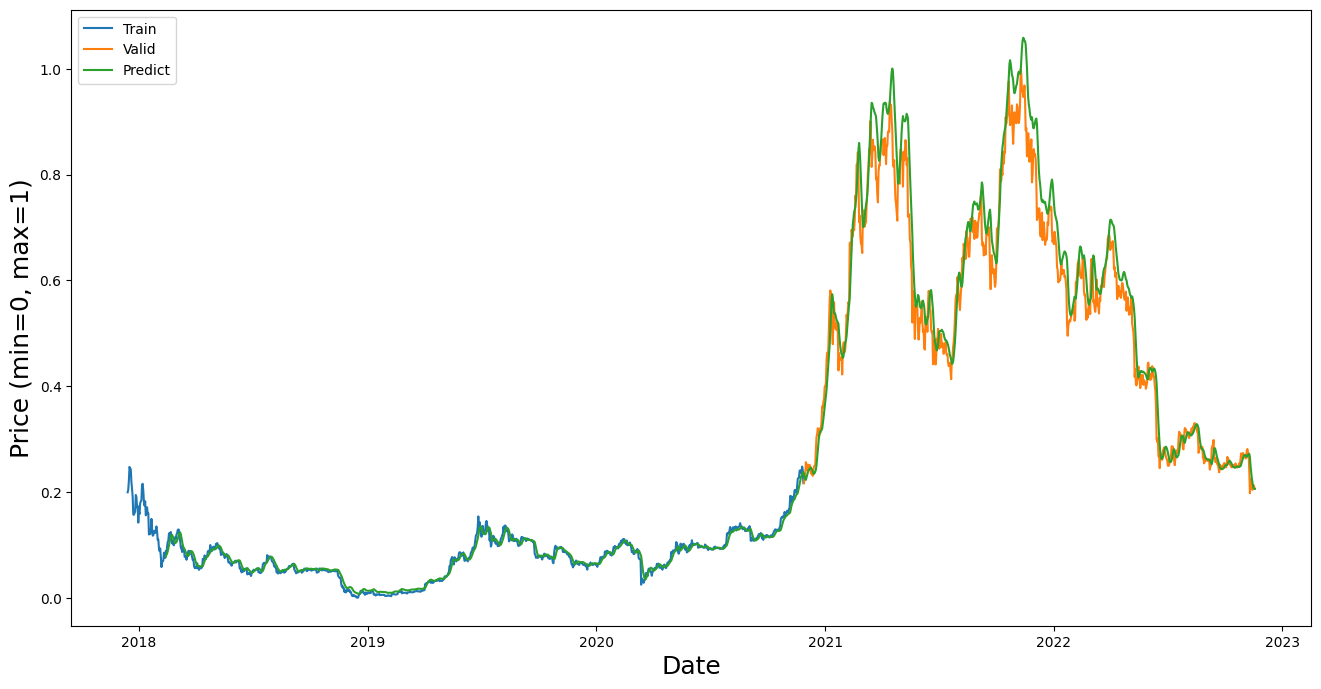

In [348]:
plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel("Price (min=0, max=1)", fontsize= 18)
plt.plot(train["price"])
plt.plot(valid["price"])
plt.plot(predictions["price"])
# plt.plot(predictions
plt.legend(["Train","Valid", "Predict"],loc="upper left")
plt.show()



In [339]:
df = spark.read.parquet(f"hdfs://hadoop-namenode:9000/crypto/{symbol}/{PERIOD}.parquet")
df = df.sort(df["open_time"].asc())
df = df.select(["date","open"]).withColumn("open", df["open"].cast(IntegerType()))
assember = VectorAssembler(inputCols=["open"],outputCol="feature_vector")
df_transformed = assember.transform(df)
scaler = MinMaxScaler(min=0,max=1,inputCol="feature_vector",outputCol="scaled_feature")
scaler = scaler.fit(df_transformed)
df_transformed = scaler.transform(df_transformed)
df = df_transformed.select(["date","scaled_feature"]).withColumn("scaled_feature", vector_to_array("scaled_feature")).select(["date"] + [col("scaled_feature")[i] for i in range(1)])
data = np.array(df.collect())
test_data = data[:]
x_test = []
y_test = []

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i, 1])
    y_test.append(test_data[i, 0])
x_test = np.array(x_test)    

x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

x_test = np.asarray(x_test).astype('float32')
predictions = model.predict(x_test)

55/55 [==============================] - 1s 10ms/step


In [342]:
y_test = np.array(y_test)   

In [343]:
predictions = np.concatenate((y_test.reshape((-1,1)),predictions.reshape((-1,1))), axis=1)
predictions = pd.DataFrame(predictions, columns=["date","price"])
predictions = predictions.set_index("date")

In [344]:
predictions

,price
date,
2018-02-13,0.078025
2018-02-14,0.081384
2018-02-15,0.083836
2018-02-16,0.087811
2018-02-17,0.093223
...,...
2022-11-14,0.217931
2022-11-15,0.210977
2022-11-16,0.206863


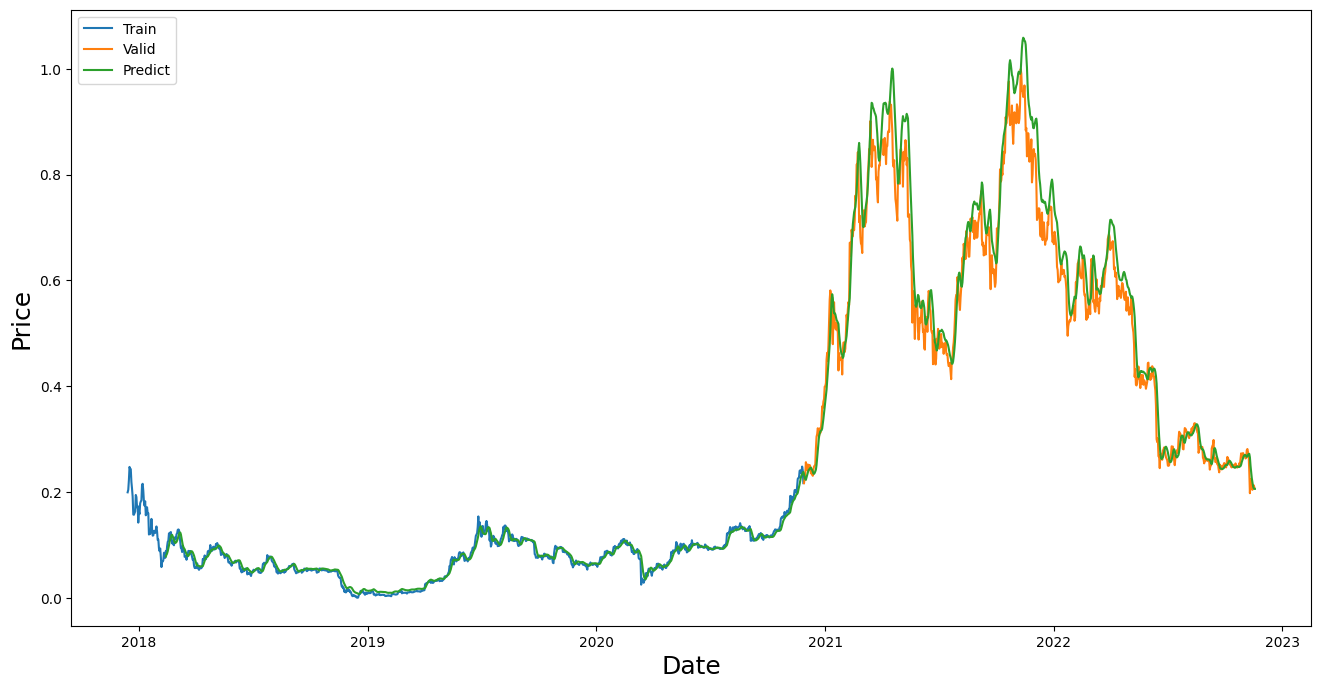

In [347]:
plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel(plt.ylabel("Price"Price (min=0, max=1)"", fontsize= 18)
, fontsize= 18)
plt.plot(train["price"])
plt.plot(valid["price"])
plt.plot(predictions["price"])
# plt.plot(predictions
plt.legend(["Train","Valid","Predict"],loc="upper left")
plt.show()


In [ ]:
spark.stop()